#Facebook Ads


all the librairies that will be used for this analysis

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [0]:
df = pd.read_csv('FacebookAds.csv')

In [5]:
sumup = f"this dataset is made of {df.shape[0]} rows and {df.shape[1]} columns.\n \ndataset sneak peak : \n"
print(sumup)
df.head()

this dataset is made of 3516 rows and 25 columns.
 
dataset sneak peak : 



,AdID,AdText,Clicks,Impressions,Age,CreationDate,EndDate,LandingPage,Location,Behaviors,Placements,PeopleWhoMatch,Interests,Language,FriendsOfConnections,ExcludedConnections,Gender,Generation,Politics,CustomAudience,AdSpend,AdSpendCurrency,SourceFile,SourceZip,pages
0,374,Join us because we care. Black matters.,0.0,137.0,18 - 65+,06/10/15 02:59:53 AM PDT,NaN,https://www.facebook.com/Black-Matters-1579673...,United States: Baltimore (+20 km) Maryland; St...,NaN,News Feed on desktop computers or News Feed on...,NaN,NaN,English (UK) or English (US),NaN,Exclude people who like Black Matters,NaN,NaN,NaN,NaN,44.87,RUB,/2015-06/P(1)0000054.pdf,2015-q2.zip,2
1,655,NOT EVERY BOY WANTS TO BE A SOLDIER. A beautif...,35.0,452.0,18 - 65+,06/23/15 07:04:01 AM PDT,06/24/15 07:04:00 AM PDT,https://www.facebook.com/LGBT-United-839497472...,Living In: United States,NaN,News Feed on desktop computers or News Feed on...,"People who like LGBT United,",NaN,NaN,Friends of people who are connected to LGBT Un...,NaN,NaN,NaN,NaN,NaN,184.81,RUB,/2015-06/P(1)0000180.pdf,2015-q2.zip,2
2,664,"""People can tolerate two homosexuals they see ...",26.0,374.0,18 - 65+,06/23/15 07:02:40 AM PDT,06/24/15 07:02:39 AM PDT,https://www.facebook.com/LGBT-United-839497472...,Living In: United States,NaN,News Feed on desktop computers or News Feed on...,"People who like LGBT United,",NaN,NaN,Friends of people who are connected to LGBT Un...,NaN,NaN,NaN,NaN,NaN,99.95,RUB,/2015-06/P(1)0000182.pdf,2015-q2.zip,2
3,79,?????? ??? ????? ? ??????????,0.0,31.0,18 - 65+,06/09/15 03:50:21 AM PDT,06/11/15 03:48:00 AM PDT,https://www.facebook.com/pages/L-for-life/9949...,United States,NaN,"News Feed on desktop computers, News Feed on m...",NaN,NaN,English (UK) or English (US),NaN,Exclude people who like L for life,NaN,NaN,NaN,NaN,33.59,RUB,/2015-06/P(1)0001844.pdf,2015-q2.zip,2
4,325,California... knows how to party California......,4.0,326.0,18 - 65+,06/10/15 07:34:52 AM PDT,06/11/15 07:34:51 AM PDT,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",NaN,News Feed on desktop computers or News Feed on...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.94,RUB,/2015-06/P(1)0002111.pdf,2015-q2.zip,1


##1st overview : 

checking basic correlations between the amount of money spent on a ad and the number of clicks & impressions it got.

* filtering some missing values

In [7]:
df1 = df[(df.Impressions.isnull()==False) & (df.Clicks.isnull()==False) & (df.AdSpend.isnull()==False)]
sumup = f"down from {df.shape[0]} rows to {df1.shape[0]} rows after removing missing values in the Impressions, Clicks, and AdSpend columns"
sumup

'down from 3516 rows to 2461 rows after removing missing values in the Impressions, Clicks, and AdSpend columns'

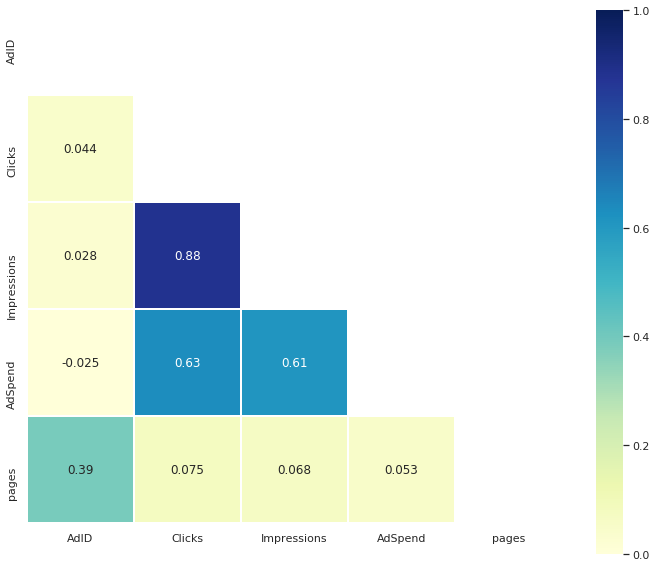

In [8]:
def heatmap(a):  
  mask = np.zeros_like(a.corr())
  mask[np.triu_indices_from(mask)] = True
  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(a.corr(), mask=mask, vmax=1,vmin=0, square=True,annot=True, 
                    linewidths=1,xticklabels=1, yticklabels=1,cmap="YlGnBu", ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5,top) #fixing the display on screen  

heatmap(df1)

From the correlation heatmap above, we see there's an obvious correlation between the number of clicks and the number of impressions that an ad gets (the closer to 1 a correlation is, the stronger). 

The correlation is softer between the number of clicks and impressions received by an ad, and the amount of money spent to promote this same ad. Thus, the dataset appears to be consistent with what one would expect.


the next anlysis step is to assess what format ads take : 

- for computer desktop view only
- for mobile app view only
- for both 

I will create a new dataframe called Placement, on which I will implement several filtering and sorting processes.

In [9]:
# new dataset called placement, filtering missing values in future important columns
placement = df[(df.Placements.isnull()==False) & (df.Location.isnull()==False)
              & (df.Interests.isnull()==False) & (df.AdText.isnull()==False)
              & (df.CreationDate.isnull()==False)]

# only keeping the dataset columns I deem the most important for the next steps
placement = placement[['AdText', 'Clicks', 'Age', 'Placements','CreationDate','EndDate','Interests','AdSpend']]
# removing useless double spaces
placement.Placements = placement.Placements.str.strip().apply(lambda x : x.replace('  ',' '))
placement.shape


(2682, 8)

In [10]:
# filling missing values in the 'End Date' column with those of the 'Creation Date' values
# I will consider the concerned ads were on for 1 day only, as I lack more information
placement.EndDate.fillna(placement.CreationDate, inplace=True)

# cleaning the values in the Creation and End Dates columns
# For each row, I only keep the date information contained within the first 8
# elements of the string. For instance '06/23/15 07:08:58 AM PDT' becomes '06/23/15'.
placement.CreationDate = placement.CreationDate.apply(lambda x : x[:8]) 
placement.EndDate = placement.EndDate.apply(lambda x : x[:8]) 
placement['CreationDate'] = pd.to_datetime(placement['CreationDate'])
placement['EndDate'] = pd.to_datetime(placement['EndDate'])

# Now, I create the column 'Runtime', which will show the number of days each ad was online for
placement['Runtime'] = placement.EndDate - placement.CreationDate
placement.Runtime = placement.Runtime.dt.days 
# Then, I make sure that all ads have at least a duration of 1 day.
# If original runtimes were 0, 1, 2 days, etc, it now becomes 1, 2, 3 days, etc.
placement.Runtime = placement.Runtime.apply(lambda x : x+1) 


# for some reason, the dataset contains 175 rows where the End Date happens before the 
# Creation Date. As I don't know how to explain this nonsense, I decided to just drop 
# these rows and only keep the one that have consistent data.
placement = placement[placement.Runtime>=1]
placement.shape

(2507, 9)

* cleaning step 

grouping and sorting the original values in the Placements column. Here are the values I have to group together, and their occurence number of the righ end of the screen : 


In [11]:
placement.Placements.value_counts()

News Feed on desktop computers or News Feed on mobile devices                                                          1756
News Feed on desktop computers, News Feed on mobile devices or Right column on desktop computers                        308
News Feed on desktop computers                                                                                          106
Instagram Feed                                                                                                          103
News Feed on desktop computers or News Feed on mobile devices Exclude                                                    83
News Feed on mobile devices                                                                                              50
lnstagram Feed                                                                                                           30
News Feed on desktop computers or News Feed on mobile devices Interest expansion                                         13
News Fee

In [12]:
# sorting loop
for i in range(len(placement.Placements)):
  if placement.Placements.values[i] == 'on pages': # here, I assumed 'pages' refered to 'regular computer web pages'
    placement.Placements.values[i] = 'computers only'
  elif (placement.Placements.values[i].startswith('News Feed on desktop computers,')) == True:
    placement.Placements.values[i] = 'computers AND apps'
  elif (placement.Placements.values[i].startswith('News Feed on desktop computers or')) == True:
    placement.Placements.values[i] = 'computers AND apps'
  elif placement.Placements.values[i] =='News Feed on desktop computers':
    placement.Placements.values[i] = 'computers only'
  else :
    placement.Placements.values[i] = 'apps only'
        
placement.Placements.value_counts()

computers AND apps    2204
apps only              187
computers only         116
Name: Placements, dtype: int64

### Below, I tackle the Ad Text column. 

Each ad text contains up to several hundred words, so after a review of the different ads (with df.AdText.values), I identified 8 main categories:
- African-American activism
- LGBT activism
- Pro-police and pro-law enforcement speech
- Conservative & pro-Trump activism
- Support for veterans
- National politics (ads meant for everyone, and that try to unite people behind common values, although some ads will be more liberal or conservative than others)
- Spirituality (Christian ads & topics related to the mind's wellness)
- Feminism

I created 8 lists of keywords thanks to which I'll then be able to sort ads according to the topic they're about. The list names are shorter for convenience purposes, eg. the list about African-Americam activism is calld blm, which stands for "black lives matter" as this moto appears a lot in the dataset ads.

In [0]:
blm = ['chains','accountability','Civil Rights','killer cops','Black','misconduct',
       'brutality','afro','shot','cop','black lives','black','discrimination','racism','violent cop']

lgbt = ['lgbt', 'QUEERS','queer','LGBT','gay','bigots','homophobic','tolerance']

police = ['brave','brave Police','BLUE LIVES','uniforme','secure','officer']

conservative = ['borders','values','terror','free market','conservative','2nd','Texas','undocumented',
                'refugees','flag','hard-working','illegal','muslim','hillary','trump','islamic',
                'fighting','preservation']

national_politics = ['state','Islamophobia','us','join','america','stop','government','country','protect',
                     'president','americans']

veteran = ['Veterans','veterans']

spirituality = ['Christian','love','beautiful','lord','loves','life']

feminism = ['woman','women']

# function to find ad texts related to a specific topic and change it into a category name
def sorting(a,b,c):
  a.AdText = a.AdText.apply(lambda x : np.where(b in x, c, x))


In [0]:
# each ad that contains the words 'Veterans' or 'veterans' will have its ad text changed to 'veteran support'
# the order in which I sort the ads matter. I want to make sure all the ads containing the word
# 'veterans' are sorted in the category 'veteran support' so I run this sorting first
def df_sorting(dataframe):
  for v in veteran :
    sorting(dataframe,v,'veteran support')
  # I run the sorting for LGBT ads right after. My list for national politics contains words 
  # like 'protect' or 'stop', which could also be present in ads related to LGBT and homophobia issues.
  # Running the LGBT topic first makes me more confident that I won't wrongly sort ads related to it.
  for l in lgbt : 
    sorting(dataframe,l,'lgbt topic')
  for s in spirituality : 
    sorting(dataframe,s,'spirituality')
  for p in police:
    sorting(dataframe,p,'pro-police')
  for f in feminism:
    sorting(dataframe,f,'feminism')
  for c in conservative :
    sorting(dataframe,c,'conservative')
  for b in blm:
    sorting(dataframe,b,'black lives matter')

  #because national_politics is the broadest topic, it's important I run its sorting
  # last so it doesn't include ads that should have been put in a different category.
  for n in national_politics:
    sorting(dataframe,n,'national politics')
df_sorting(placement)


As not all the ads in the dataset were sorted in the previous step, I chose to drop the one that didn't fit in any of my categories for the rest of my analysis. I considered I had a sufficient amount of data left to proceed.

In [20]:
categories=['veteran support','lgbt topic','spirituality','pro-police','feminism',
           'conservative','black lives matter','national politics']
placement=placement[placement.AdText.isin(categories)]
sumup = f"my new dataset now has {placement.shape[0]} rows and {placement.shape[1]} columns"
sumup

'my new dataset now has 1872 rows and 9 columns'

## Filtering ads by Age Groups

The age column contains several categories, such as 18-65+ (everyone from 18 years old), or 13-30 (people between 13 and 30 years old). I segmented all these categories into 5 bigger groups :

- all adults 18 - 65+ , 16 - 65+ 

- working adults : age groups that end in the 50s, such as 18 - 54, or that end in the 60s without a + sign at the end, such as 17 - 61. 

- no babyboomers : age groups that end in the forties, such as 13 - 40.

- millenials : age groups that end in the 10s, 20s, or 30s, or people born in the 1980s and after.

- no millenials : the age group 35 - 65+



In [21]:
placement.Age = placement.Age.apply(lambda x : np.where(x=='35 - 65+','NO MILLENIALS',x))
placement.Age = placement.Age.apply(lambda x : np.where(x[-1]=='+','ALL ADULTS',x))

def segmentation(a,b):
  placement.Age = placement.Age.apply(lambda x : np.where(x[-2]==a,b,x))
  
segmentation('5','WORKING ADULTS')
segmentation('6','WORKING ADULTS')
segmentation('4','NO BABYBOOMERS')
segmentation('3','MILLENIALS')
segmentation('2','MILLENIALS')
segmentation('1','MILLENIALS')

placement.Age.value_counts()

ALL ADULTS        1377
WORKING ADULTS     221
NO BABYBOOMERS     125
MILLENIALS         121
NO MILLENIALS       28
Name: Age, dtype: int64

Now I create dummies with the Age column, and then, I'll be able to visualise potential correlations between the different age groups and the topics they're being targeted with.

In [0]:
placement = pd.get_dummies(placement , columns=['Age'])
placement.drop(['CreationDate','EndDate'],axis=1,inplace=True)

In [23]:
p2=placement.groupby(['AdText']).agg('mean').sort_values('Clicks')
col_list = ['Age_ALL ADULTS', 'Age_MILLENIALS', 'Age_NO BABYBOOMERS','Age_NO MILLENIALS', 'Age_WORKING ADULTS']
for i in col_list:
  p2[i]=p2[i].apply(lambda x : round(x*100,1)) #express values in percentages
p2

,Clicks,AdSpend,Runtime,Age_ALL ADULTS,Age_MILLENIALS,Age_NO BABYBOOMERS,Age_NO MILLENIALS,Age_WORKING ADULTS
AdText,,,,,,,,
veteran support,146.309524,1440.881538,1.833333,71.4,14.3,0.0,0.0,14.3
conservative,721.640693,3141.864304,2.236735,80.0,1.6,4.1,9.0,5.3
spirituality,775.161290,1445.063641,2.757143,86.1,0.4,4.3,0.0,9.3
national politics,1017.336032,3100.919277,2.645545,60.6,18.6,7.7,1.2,11.9
black lives matter,1200.258389,2127.794039,3.672727,74.2,2.5,9.6,0.0,13.7
lgbt topic,1396.804878,3773.038276,2.390244,85.4,0.0,0.0,0.0,14.6
pro-police,1476.457447,2826.826290,5.297872,72.3,0.0,4.3,0.0,23.4
feminism,1598.813559,705.249643,2.866667,86.7,1.7,3.3,0.0,8.3


Noticeable figures in the table above:
- Ads about feminism get the highest average number of clicks
- Ads about LGBT topic cost an average of 3773 rubles each (the original dataset indicated all the ads had been paid for in russian rubles)
- Ads about Pro-police speech were online the longest on average, during a bit less than 4 and a half days
- Ads about support for veterans have a Placement category avergage of over 1, which means most of these ads were only shown on computers.
- Most ads target the age group 'All Adults', but ads about conservative topics and about national politics are the 2 categories that try to target all of the age groups.
- The older age group, No Millenials, people 35 and older, is the least targeted group. It mostly sees ads about conservative topics and a few about national politics, probably because the elderly is considered a much more conservative (anti-immigation and pro-law enforcement) and politics-involved age group than other demographics. 
- Teenagers and working adults (the No Babyboomer group) mostly see ads about African-American activism, as people from younger generations are seen as more concerned than their parents' generation about the struggles people of color experience in America.
- ads supporting the police have the longest average runtime, more than 5 days
- feminism and spirituality are the two topics that target all adults the most. For spirituality, it could be explained by the fact that the US is still a strongly religious country compared to other well-developed economies. For feminism, it might be because the gender pay gap has become a broad issue, regarless of people's political affiliation.

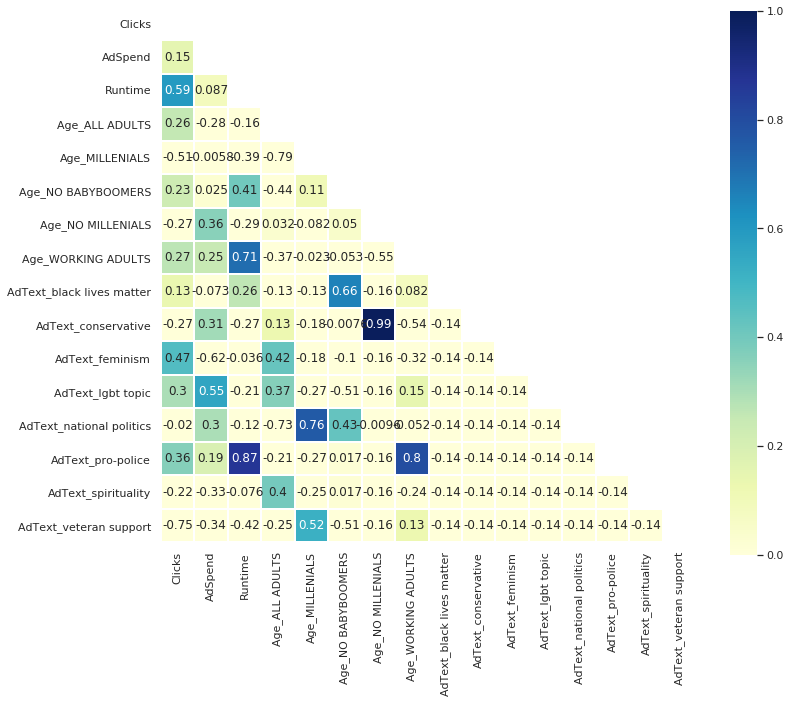

In [24]:
p2.reset_index(inplace=True)
p2 = pd.get_dummies(p2 , columns=['AdText'])

heatmap(p2)

Above, we can see :
- the non-Millenial group (35 years old and older) is almost exclusively targeted with ads from the conservative category
- Millenials are particularly targeted with ads related to national politics, which makes sense because young people are new voters and all political parties want to appeal to them. This same age group is also significantly targeted by ads supporting veterans, maybe because advertisers want to grow Millenials' patriotism feelings ? 
- Pro-police ads overwhelmingly target working-age adults, as they want to trigger people's desire for order and security.
- Ads about African-American activism seems to purposely avoid older people and target the No babyboomers age group, as older people tend to have less inclusive and empathic views regarding people of color, some might argue.

In [25]:
p3 = pd.get_dummies(placement , columns=['Placements'])
col_list = ['Placements_computers only','Placements_computers AND apps', 'Placements_apps only']
p3=p3.groupby(['AdText']).agg('mean').sort_values('Placements_computers AND apps')
for i in col_list:
  p3[i]=p3[i].apply(lambda x : round(x*100,1))
p3=p3[col_list]
p3

,Placements_computers only,Placements_computers AND apps,Placements_apps only
AdText,,,
veteran support,0.0,47.6,52.4
national politics,21.4,68.3,10.3
conservative,0.4,91.8,7.8
black lives matter,0.5,92.4,7.1
lgbt topic,0.0,92.7,7.3
feminism,0.0,93.3,6.7
pro-police,0.0,95.7,4.3
spirituality,0.0,96.1,3.9


Highlights seen above :
- Most advertisers stoped designing ads for computer screens only, which is consistent with the shift of the ad industry towards online mobile devices' screens.
- Ads about veteran support are the only ones that are more often shown elsewere than on a computer screen. 52.4% of these ads are displayed on mobile apps, such as Instagram or Facebook App
- National politics is the category with the least unbalanced repartition of ads between computer and mobile screens.
- Advertisers obviously favor mobile-app-only ads over computer-only ads, proving the ad industry fully understands the importance of designing ads specifically for smartphone screens to be able to reach a new and younger market segment.

###Now, I want to analyse ads based on their runtime : the number of days they were online

In [26]:
runtime = placement[['AdText','Clicks','Runtime']]
runtime=runtime[(runtime.Clicks>0)]
runtime.shape

(1336, 3)

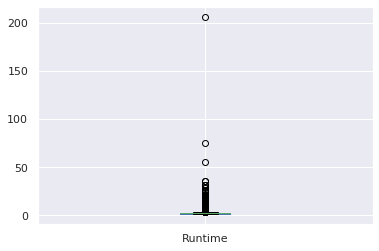

In [27]:
runtime.boxplot(column = 'Runtime')
#most ads were only online for less than 5 days, approximately
plt.show()

From the outlier chart above, with the Y axis standing for the number of days ads were shown, we can approximately guess 75% of the ads in the dataset were online for 5 days or less. 
- Only 3 ads were online for more than 50 days
- Only 1 was online for more than 200 days

In [28]:
# a contains ads that were ran for 7 days or less
a = runtime[(runtime.Runtime>=1) & (runtime.Runtime<7)]
a.shape

(1236, 3)

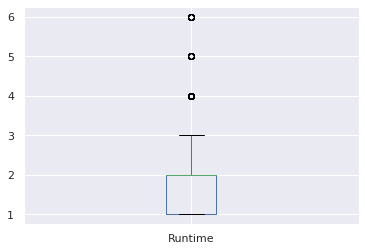

In [29]:
a.boxplot(column = 'Runtime')

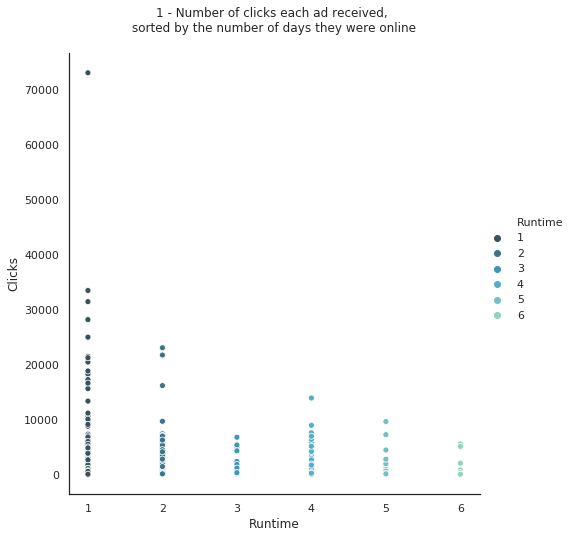

In [30]:
sns.set_style("white")
sns.relplot(x="Runtime", y="Clicks", hue="Runtime",height=7,
            data=a,palette=sns.color_palette('GnBu_d'))
plt.title('1 - Number of clicks each ad received, \n sorted by the number of days they were online \n')
plt.show()

For the chart above, you can surprinsingly conclude that ads don't necessarily get more clicks when they stay online longer than others. The overall trend tends to be the opposite of that assumption.

<Figure size 432x288 with 0 Axes>

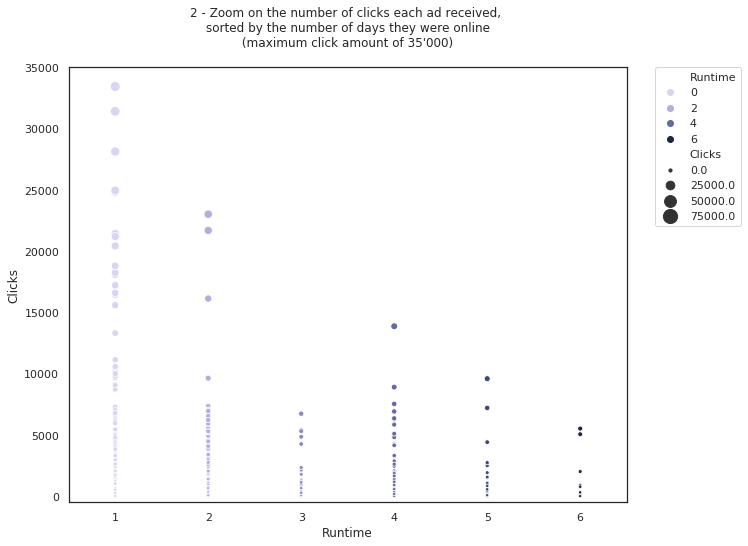

In [34]:
sns.despine()
cmap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x="Runtime", y="Clicks",
                     hue="Runtime", size="Clicks",
                     palette=cmap, sizes=(10, 200),
                     data=a)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-500, 35000)
plt.xlim(.5, 6.5)
plt.title('2 - Zoom on the number of clicks each ad received, \n sorted by the number of days they were online \n (maximum click amount of 35\'000) \n')
plt.show()

graph above :
- the more days the ads were on, the darker their dots are
- the more the ads got clicks, the bigger their dots are

below: a visualization of the top 5 most clicked ads in the dataset 'placement'. We can see they were all online for 1 day only.

In [35]:
most_clicked=placement[placement.Clicks>20000]
most_clicked = most_clicked[['AdText','Clicks','Interests','AdSpend','Runtime']]
most_clicked.sort_values('Clicks',inplace=True)
most_clicked.tail()

,AdText,Clicks,Interests,AdSpend,Runtime
2084,spirituality,24955.0,2nd Amendment,48305.55,1
3249,national politics,28137.0,Jesus,89081.11,1
553,black lives matter,31413.0,Human rights or Malcolm X,NaN,1
2436,black lives matter,33444.0,"Martin Luther King, Jr., African-American Civi...",58193.59,1
2055,pro-police,73063.0,"Support Law Enforcement, The Thin Blue Line, O...",110587.67,1


In the chart below, I visualize the sum (hence the variable name 'sm') of all the clicks gotten by ads grouped by their runtimes and by their topics :

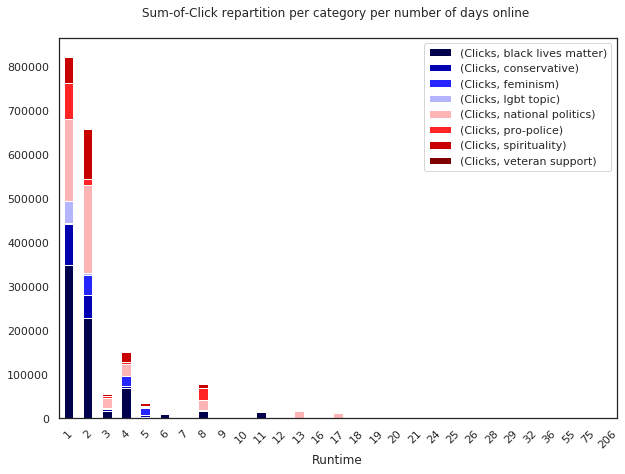

In [36]:
sm = runtime.set_index(['Runtime','AdText'])
sm = sm.sum(level=[0,1]).unstack(fill_value=0).stack()
sm.unstack().plot(kind='bar',figsize = (10, 7), stacked=True, 
                  title='Sum-of-Click repartition per category per number of days online \n',colormap="seismic")
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

However, because the data is so spread out, I switched from the sum to the average of received clicks for ads grouped again by their runtimes and their topics : 

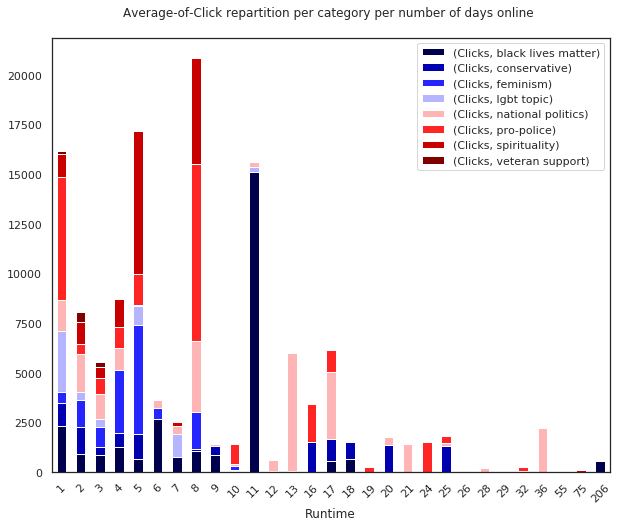

In [37]:
mn = runtime.set_index(['Runtime','AdText'])
mn = mn.mean(level=[0,1]).unstack(fill_value=0).stack()
mn.unstack().plot(kind='bar', stacked=True, figsize=(10,8),
                  title='Average-of-Click repartition per category per number of days online \n',colormap="seismic")
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

It is difficult to find a pattern in the data displayed above. The most striking information is that ads about Afrian American activism that were online for 11 days have the highest average click number of all. Let's check below what ads are included in this figure : 

In [38]:
runtime[runtime.Runtime==11]

,AdText,Clicks,Runtime
1183,lgbt topic,240.0,11
1712,national politics,1042.0,11
1767,national politics,276.0,11
2832,national politics,19.0,11
2842,national politics,33.0,11
2846,national politics,28.0,11
2945,black lives matter,15124.0,11
3189,national politics,198.0,11


In fact, only one ad about African American activism was online for 11 days, and its high number of clicks twisted the results on a large scale.

This next chart is a close-up on the click average for ads ran between 3 and 8 days, just so that we get a clearer picture of what was happening with these.

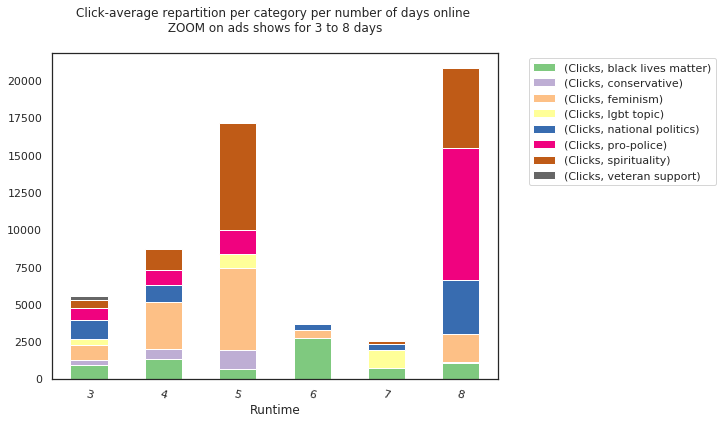

In [40]:
zoomed = runtime[(runtime.Runtime>=3) & (runtime.Runtime<9)]

z = zoomed.set_index(['Runtime','AdText'])
z = z.mean(level=[0,1]).unstack(fill_value=0).stack()
z.unstack().plot(kind='bar',figsize=(8,6), stacked=True, 
                 title='Click-average repartition per category per number of days online \n ZOOM on ads shows for 3 to 8 days \n',
                 colormap="Accent")
plt.xticks(rotation = 345)
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show()

There doesn't seem to be a consistent logic in the evolution of the average amount of clicks. It seems pro-police ads do much better when they're ran for a full week than for 3 to 5 days, but the opposite seems to be true for ads about feminism or spirituality.

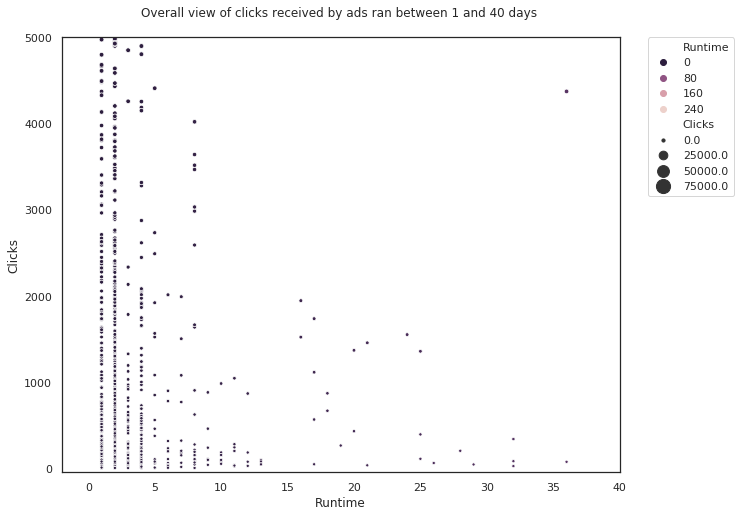

In [41]:
#sns.set_style("white")
#sns.despine()
cmap = sns.cubehelix_palette(reverse='True', as_cmap=True)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x="Runtime", y="Clicks",
                     hue="Runtime", size="Clicks",
                     palette=cmap, sizes=(10, 200),
                     data=runtime)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-50, 5000)
plt.xlim(-2, 40)

plt.title('Overall view of clicks received by ads ran between 1 and 40 days \n')
plt.show()

Now, I'm going to analyse the relation between ads, their topics, and the amount of money spent to promote them. For this, I'm creating a new dataframe called spending_topic :

In [43]:
spending_topic = df[(df.Clicks.isnull()==False)& (df.AdSpend.isnull()==False) & (df.CreationDate.isnull()==False) & (df.EndDate.isnull()==False)& (df.Placements.isnull()==False)]
spending_topic = spending_topic[['AdText', 'Clicks', 'AdSpend']]
#Impressions & Clicks are so highly correlated auto colinearity I chose to drop Impressions
spending_topic.AdText = spending_topic.AdText.apply(lambda x : str(x))
spending_topic.head()

,AdText,Clicks,AdSpend
1,NOT EVERY BOY WANTS TO BE A SOLDIER. A beautif...,35.0,184.81
2,"""People can tolerate two homosexuals they see ...",26.0,99.95
3,?????? ??? ????? ? ??????????,0.0,33.59
4,California... knows how to party California......,4.0,45.94
6,"'Just like Trayvon Martin, race mattered for A...",7.0,34.77


In [46]:
spending_topic=spending_topic.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
keywords = [str(element) for element in spending_topic.AdText.values]
keywords = ' '.join([element for element in keywords])
keywords=keywords.split()

to_strip=[',',';','(',')','\'','-','.','?']
for i in range(len(keywords)):
  for element in to_strip:
    keywords[i] = keywords[i].replace(element,'')
sumup = f"number of words to analyze : {len(keywords)}"
sumup
# here, I created a list of 93'107 words from all the words from every ad text in the dataset.
# I also removed some special characters as a first cleaning step.

'number of words to analyze : 93107'

Now I define a list of stopwords, words I will need to remove from my analysis, such as 'or','and','to','I'm', etc, because they are not relevant.

In [0]:
stop = stopwords.words('english')
to_add=['join','take','or','nan','imgur','service','last','ur','like','face',
        'info','join','take','will','want','dudeers','comment','youre']
# because I've completed the analyses already, I know the words above needed to be included
# in my stopword list
for item in to_add:
  stop.append(item)

Now I'm getting the count of occurence for each important word used in the ad texts, from the most popular one to the least : 

In [48]:
keywords = [i for i in keywords if i not in stop]
counts = Counter(keywords)
print(counts)

Counter({'black': 1015, 'police': 500, 'people': 419, 'us': 366, 'one': 209, 'dont': 202, 'america': 198, 'man': 192, '': 177, 'blackmattersuscom': 176, 'matters': 175, 'american': 168, 'white': 158, 'said': 140, 'new': 139, 'officer': 131, 'cops': 131, 'know': 123, 'officers': 121, 'country': 120, 'make': 120, 'lives': 117, 'years': 116, 'stop': 116, 'follow': 112, 'bm': 111, 'first': 110, 'school': 109, 'time': 107, 'day': 106, 'government': 105, 'need': 104, 'would': 104, 'video': 102, 'shot': 100, 'feel': 99, 'two': 97, 'even': 97, 'never': 96, 'friends': 96, 'free': 94, 'bring': 93, 'many': 92, 'think': 91, 'americans': 90, 'history': 89, 'safe': 89, 'rights': 87, 'family': 86, 'life': 86, 'racism': 84, 'also': 84, 'women': 84, 'get': 83, 'killed': 83, 'united': 83, 'see': 82, 'support': 81, 'still': 80, 'woman': 80, 'states': 80, 'love': 79, 'justice': 78, 'system': 78, 'students': 78, '#blacklivesmatter': 78, 'thats': 77, 'event': 77, 'way': 77, 'repost': 77, 'lets': 76, 'trump'

In [49]:
#I run df_sorting again, this time on a different dataset
df_sorting(spending_topic)
spending_topic=spending_topic[spending_topic.AdText.isin(categories)]
spending_topic.AdText.value_counts()

black lives matter    418
national politics     251
spirituality          217
conservative          158
pro-police            140
feminism               66
lgbt topic             60
veteran support        21
Name: AdText, dtype: int64

In Spending_topic2, I aim to analyse the average cost for 1 click depending on the ads' topics :


In [50]:
spending_topic2=spending_topic.groupby(['AdText']).agg('mean')
spending_topic2['Cost_of_1Click'] = spending_topic2.AdSpend/ spending_topic2.Clicks
spending_topic2.sort_values('Cost_of_1Click',ascending=False)

,Clicks,AdSpend,Cost_of_1Click
AdText,,,
conservative,781.879747,1912.089747,2.445504
veteran support,270.190476,519.036190,1.921001
lgbt topic,334.250000,628.868833,1.881433
pro-police,851.471429,626.186857,0.735417
black lives matter,925.172249,467.302919,0.505098
national politics,1518.107570,764.782749,0.503774
spirituality,1197.576037,374.374009,0.312610
feminism,1154.393939,320.309394,0.277470


We can clearly see clicks for conservative ads are the most expensive ones. 

Is it because its is very difficult to interest people with ads related to this topic ? 

Or maybe because advertisers overspend without realizing it ? 

This should be investigated, as even the average cost for 1 click on an ad supporting veterans is more than 50 cents cheaper !

Also, I'm surprised to see it was that easy to interest people with ads related to feminist activism. 

Would this data have been the same 3 or 4 years ago, before Trump's election and/or before the Harvey Weinstein scandal ?

In [209]:
print("our data lists ",spending_topic[spending_topic.AdText=="conservative"].shape[0] - spending_topic[spending_topic.AdText=="feminism"].shape[0]," conservative ads more than feminist ads, which may also explain the stark average difference")


our data lists  92  conservative ads more than feminist ads, which may also explain the stark average difference


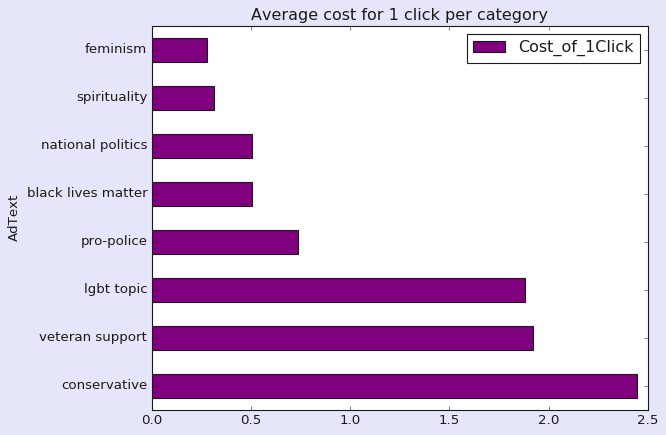

In [51]:
plt.style.use('classic')
fig, ax = plt.subplots(facecolor='lavender')
spending_topic2[['Cost_of_1Click']].sort_values('Cost_of_1Click',
                                                ascending=False).plot.barh(ax=ax,color='purple')
plt.title('Average cost for 1 click per category')
plt.show()

In [52]:
spending_topic3=spending_topic.groupby(['AdText']).agg('sum')
spending_topic3['Cost_of_1Click'] = spending_topic3.AdSpend/ spending_topic3.Clicks
spending_topic3['Cost_Diff_Percent'] = (spending_topic3.Cost_of_1Click*100)/spending_topic3.Cost_of_1Click.min()-100
spending_topic3.Cost_Diff_Percent=spending_topic3.Cost_Diff_Percent.apply(lambda x : round(x,1))
spending_topic3.sort_values('Cost_Diff_Percent',ascending=True)

,Clicks,AdSpend,Cost_of_1Click,Cost_Diff_Percent
AdText,,,,
feminism,76190.0,21140.42,0.277470,0.0
spirituality,259874.0,81239.16,0.312610,12.7
national politics,381045.0,191960.47,0.503774,81.6
black lives matter,386722.0,195332.62,0.505098,82.0
pro-police,119206.0,87666.16,0.735417,165.0
lgbt topic,20055.0,37732.13,1.881433,578.1
veteran support,5674.0,10899.76,1.921001,592.3
conservative,123537.0,302110.18,2.445504,781.4


the table above shows that, for 1 click, advertisers in the conservative category spend an average of 781.4% more money than those in the feminism category.

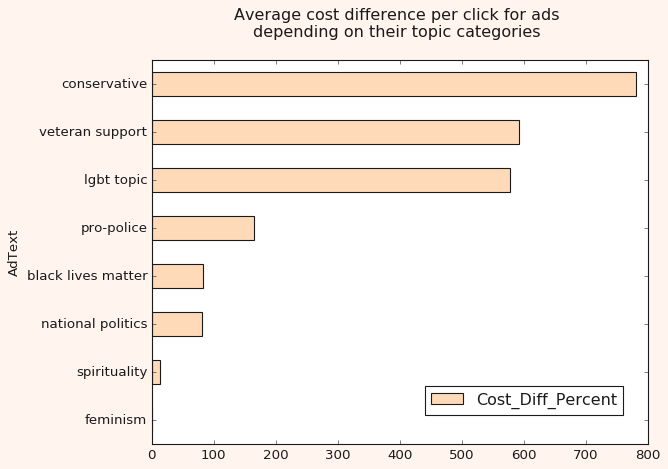

In [61]:
plt.style.use('classic')

fig, ax = plt.subplots(facecolor='seashell')

spending_topic3[['Cost_Diff_Percent']].sort_values('Cost_Diff_Percent',
                                           ascending=True).plot.barh(ax=ax,color='peachpuff')
plt.legend(bbox_to_anchor=(.55, .15), loc=2, borderaxespad=0.)
plt.title('Average cost difference per click for ads \ndepending on their topic categories \n')
plt.show()

For this last analysis, I want to assess how people are targeted solely based on their ages.
From my original dataframe, I create df2, where all the missing values in the Age column have been filtered out.

In [0]:
df2 = df[df.Age.isnull()==False]
df2=df2.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [63]:
df2.Age.value_counts()

18 - 65+    2364
16 - 65+     356
18 - 54      124
18 - 45       71
18 - 51       48
            ... 
17 - 61        1
13 - 42        1
18 - 53        1
18 - 43        1
14 - 36        1
Name: Age, Length: 64, dtype: int64

Here, I repeat the same sorting technique I used earlier on another dataset to create 5 age groups

In [64]:
df2.Age = df2.Age.apply(lambda x : np.where(x=='35 - 65+','NO MILLENIALS',x))
df2.Age = df2.Age.apply(lambda x : np.where(x[-1]=='+','ALL ADULTS',x))
def segmentation(a,b):
  df2.Age = df2.Age.apply(lambda x : np.where(x[-2]==a,b,x))

segmentation('5','WORKING ADULTS')
segmentation('6','WORKING ADULTS')
segmentation('4','NO BABYBOOMERS')
segmentation('3','MILLENIALS')
segmentation('2','MILLENIALS')
segmentation('1','MILLENIALS')
df2.Age.value_counts()

ALL ADULTS        2863
WORKING ADULTS     294
NO BABYBOOMERS     194
MILLENIALS         137
NO MILLENIALS       28
Name: Age, dtype: int64

### Word Clouds :

I'm going to design a cleaning function to clean up the word lists I'm going to analyse, and a wordcloud function, in which I picked colors of my liking

In [0]:
def cleaning(a):
  text = [element for element in a]
  text =  str(text)
  text=re.sub(r'[^a-zA-Z\s]', '', text)
  tokens = nltk.word_tokenize(text)    
  tokens = [token.strip() for token in tokens]    
  text = ' '.join([token for token in tokens if token not in stop])
  return text

from matplotlib.colors import LinearSegmentedColormap
def WC(a):
  colors = ["#BF0A30", "#002868"]
  cmap = LinearSegmentedColormap.from_list("mycmap", colors)
  wordcloud = WordCloud(width = 2000,height = 1500,max_words=25,
    background_color = 'white',random_state=1,min_font_size=30,
    stopwords = STOPWORDS,colormap=cmap).generate(str(a))
  fig = plt.figure(figsize = (10, 7),facecolor = 'k',edgecolor = 'k')
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

### About Millenials :

In [0]:
millenials = df2[df2.Age=='MILLENIALS']

analysis of the Interests column for the Millenial dataset : 
- these values are the topics that advertisers said their target market segment should have shown interest in. 
- this column can contain missing values, but I still wanted to compare the word cloud for this colum with that of the AdText column. It's a way for me to ensure I sorted my data in a consistent and relevant manner.


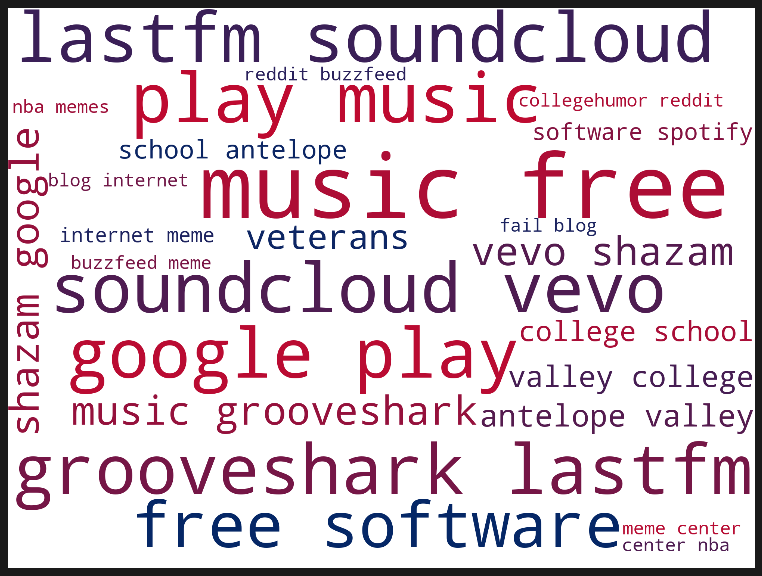

In [67]:
interests = cleaning(millenials.Interests.values)
WC(interests)

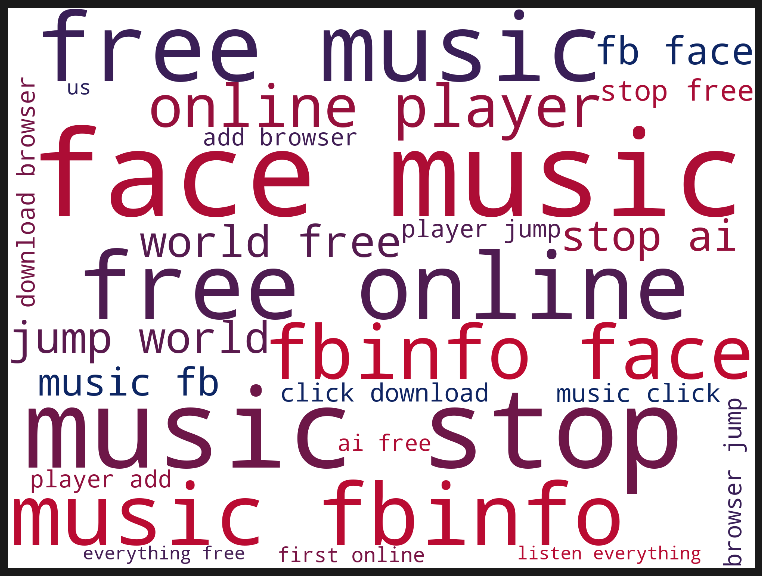

In [68]:
# analysis of the text in the ads targeting millenials
adtext = cleaning(millenials.AdText.values)
adtext=adtext.replace('share',' share').replace('com',' com').replace("music", " music ")
WC(adtext)

In [0]:
pd.options.display.max_colwidth=2000
millenials[millenials.AdText.str.contains('dudeers')]
# I wanted to know what dudeers was, it seems it's a website

### No Babyboomers refers to people up to 49 years old

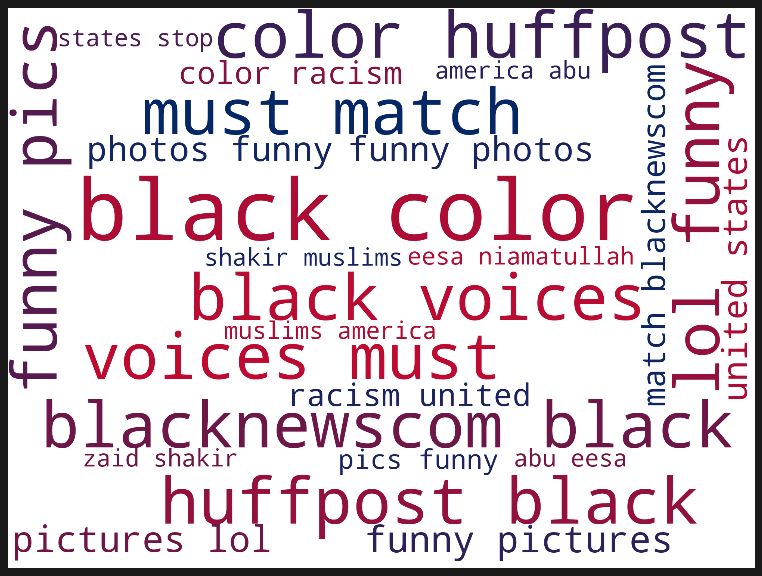

In [70]:
nobabyboomers = df2[df2.Age=='NO BABYBOOMERS']
interests = cleaning(nobabyboomers.Interests.values)
WC(interests)

### the Except_Millenials dataset refers to people who are 35 and older :

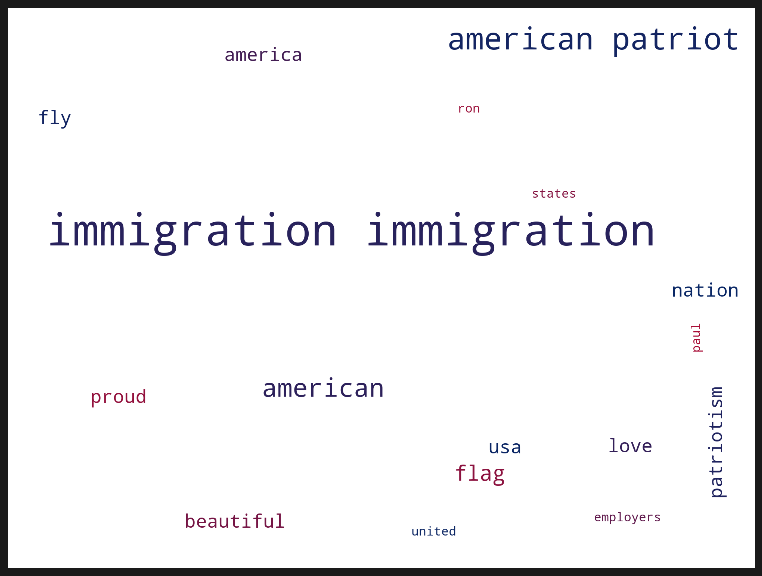

In [71]:
except_millenials = df2[df2.Age == 'NO MILLENIALS']
interests = cleaning(except_millenials.Interests.values)
WC(interests)

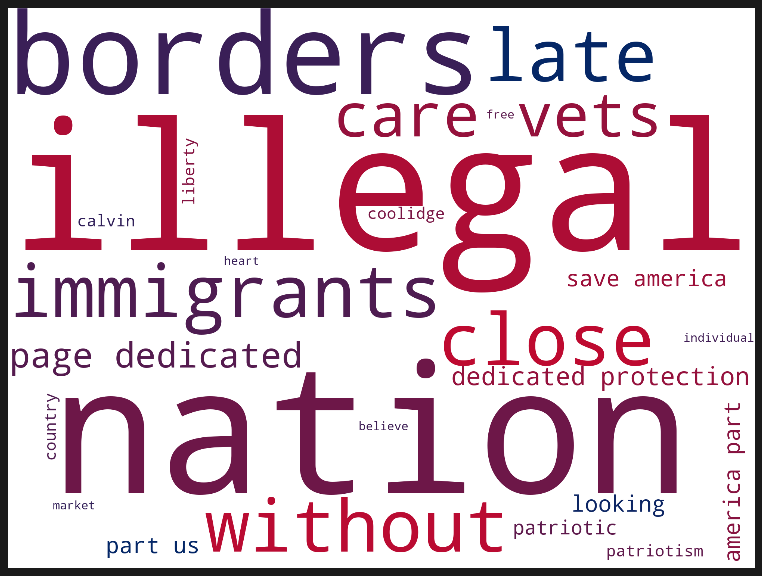

In [72]:
interests = cleaning(except_millenials.AdText.values)
WC(interests)

### All Adults is the most interesting age group as it's the larget one 

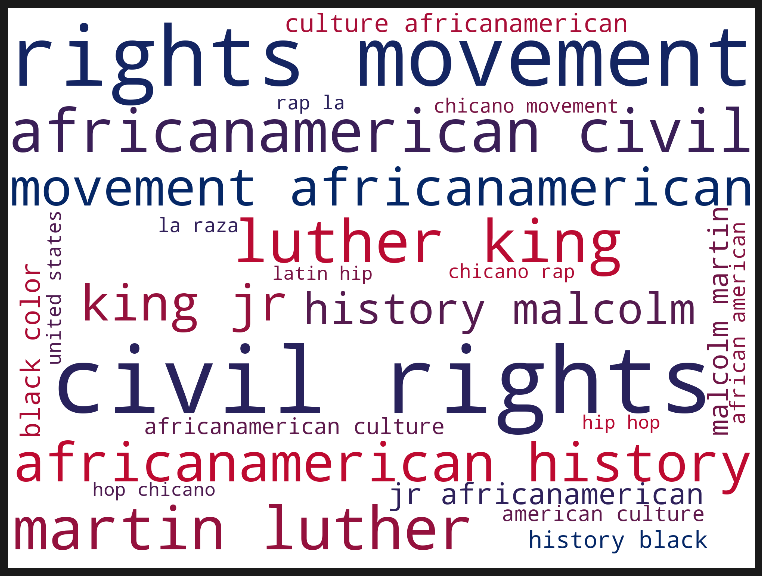

In [73]:
alladults = df2[df2.Age=='ALL ADULTS']
interests = cleaning(alladults.Interests.values)
WC(interests)

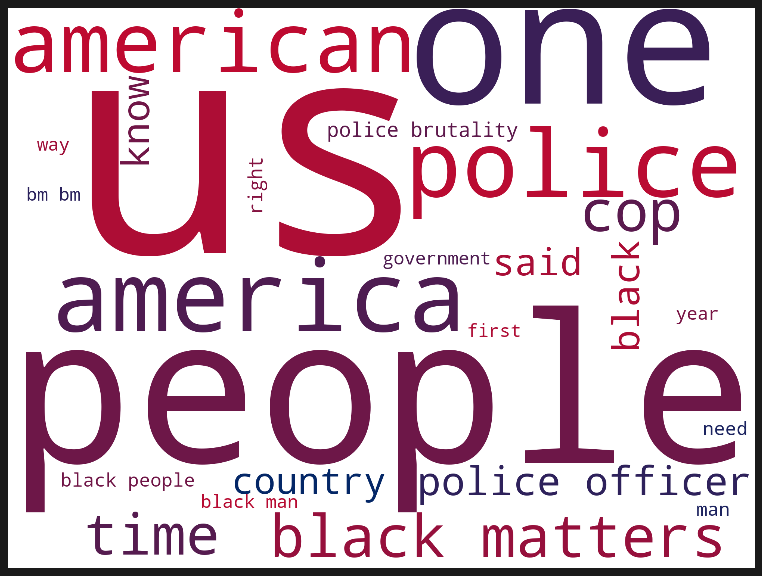

In [74]:
adtext = cleaning(alladults.AdText.values)
adtext=adtext.replace('priority',' priority').replace('com',' ').replace("facebook", " ")
WC(adtext)

### Key Takeaways : 

- Young people are targeted with entertainement ads, topics related to music, social media games, free stuff (free music, free software, Spotify, etc.)
- Older people are mostly targeted with political ads about illegal immigration and border protection. They are mostly seen as Trump supporters.
- All Adults are targeted with strong political topics that are relavant all across the country, but two sides face each other : 

the African American activists, who call out police misconduct towards people of color, 

and the conservative, who support police actions and law enforcement no matter what. 

They both use consensual words, such as : 
  - america
  - american
  - one
  - people
  - country
  - time
  - us 